In [1]:
#coding: utf-8

import warnings
warnings.simplefilter("ignore")

import os
import sys 
import wave
import time
import librosa
import numpy as np
import seaborn as sns
from utils_music import *
import matplotlib.pyplot as plt
from StringIO import StringIO
from sklearn.preprocessing import scale

%pylab inline

# sudo pip install librosa
# ubuntu: sudo apt-get install libav-tools
# OSX   : brew install libav OMP_NUM_THREADS=2

Populating the interactive namespace from numpy and matplotlib


# Get the Data

Датасет для контеста помещен вот здесь: https://yadi.sk/d/3jmeVCfSwTKgm (внимание! файл весит 3,5 Гб)


Он распаковывается в папку "musicdata". Все пути в этом ноутбуке будут относительно этой папки: "./musicdata/\*". 

Вы можете изменить базовый путь, как вам удобно.

In [2]:
BP = "./musicdata/"

# Just a Sound

Для начала попробуем поработать со звуком - послушайте любой трек, постройте график сырых данных и спектрограмму.

In [3]:
import IPython
from IPython import display

def Audio(url):
    return display.HTML("<center><audio controls><source src='{}' type=\"audio/wav\"></audio>".format(url))

In [4]:
from pydub import AudioSegment
from pydub.playback import play

In [5]:
sound_file = os.path.join(BP, "audiosamples", "short_206377.wav")
# sound_file = "./short_206377.wav"
y, sr = librosa.load(sound_file)

Audio(url=sound_file)
audio = AudioSegment.from_wav(sound_file)
play(audio[:30000])

# Sound as 1D-Signal

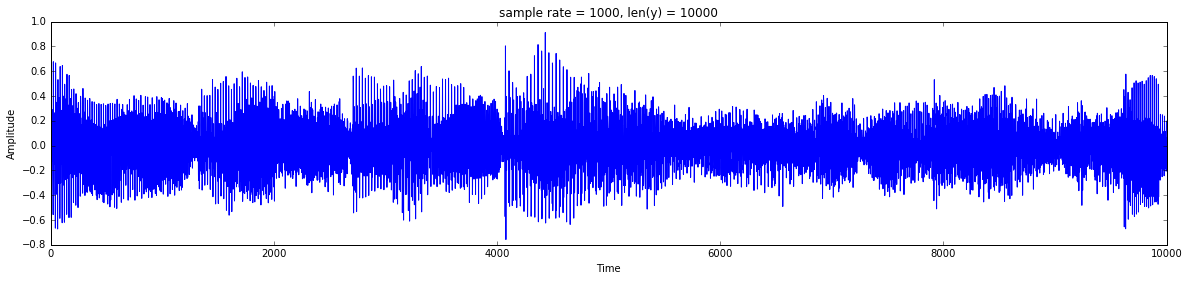

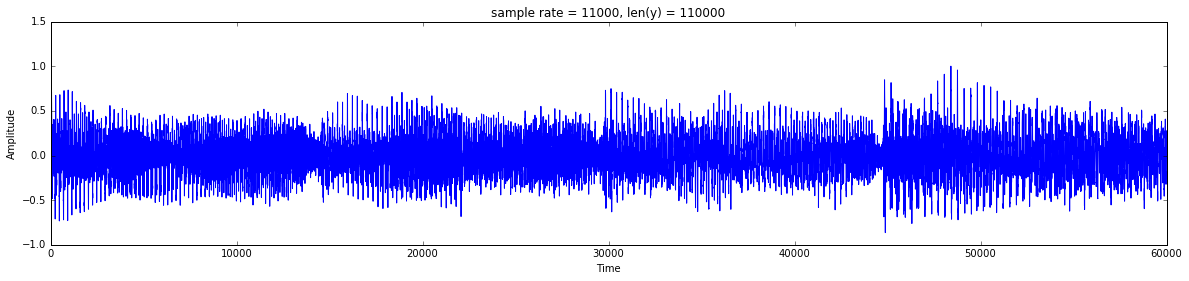

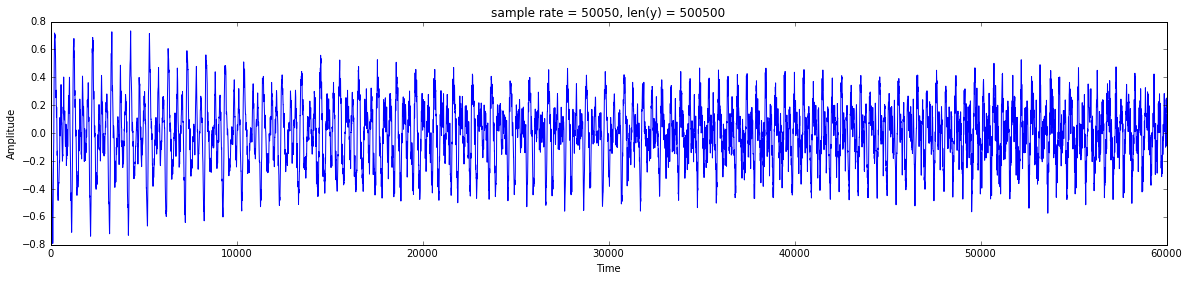

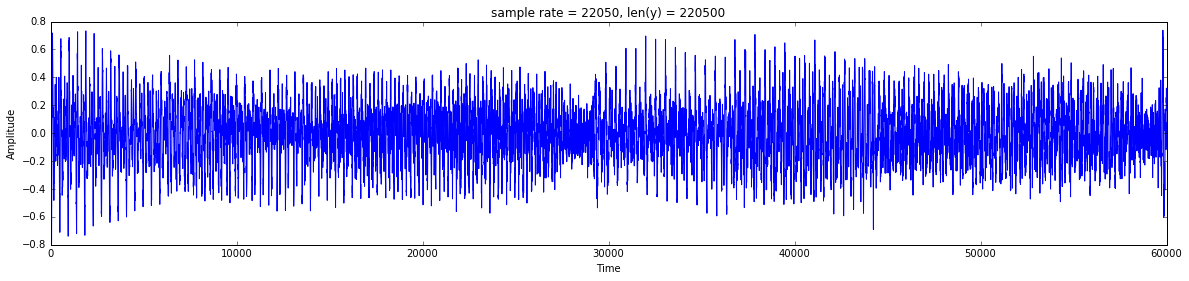

In [6]:
from scipy.io.wavfile import read

for sr in [1000, 11000, 50050, None]:
    plt.figure(figsize=(20,4))

    y, sr = librosa.load(sound_file, sr=sr)
    plt.plot(y[:60000])

    # label the axes
    plt.ylabel("Amplitude")
    plt.xlabel("Time")
    plt.title('sample rate = {}, len(y) = {}'.format(sr, len(y)))
    # 
    # Используйте pylab.plot для построения графика, нарисуйте y, sr
    #
    pylab.show()

# Sound as 2D-Signal

Нашу цель слелать из предыдущего графика картинку - для этого нам нужно оценить частоты в каждый момент времени. Благо за нас это умеет делать librosa, у которой внутри STFFT. Используйте librosa.feature.melspectrogram -- для получения спектрограммы, и librosa.logamplitude для выравнивания диапазонов частот. 

help: https://gist.github.com/mailletf/3484932dd29d62b36092

In [7]:
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
log_S = librosa.logamplitude(S, ref_power=np.max)

Нарисуйте спектрограмму, получилась красивая картинка?

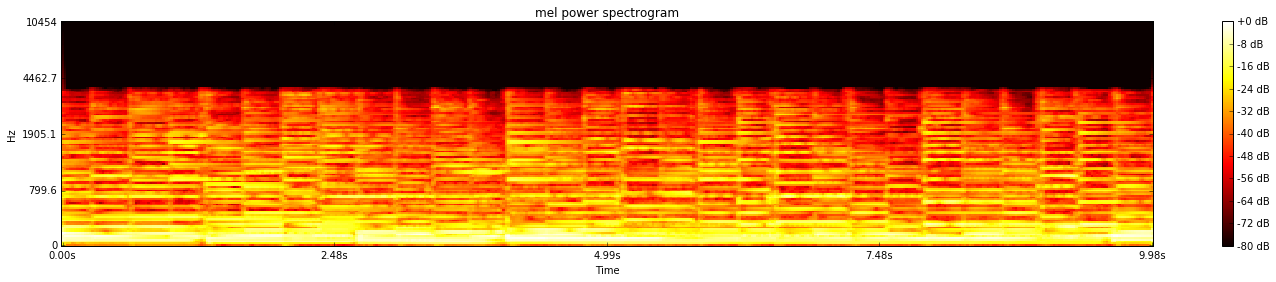

In [8]:
plt.figure(figsize=(20,4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel', cmap='hot')
plt.title('mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

# Prepare the Data

В этой секции мы создадим датасет, прочитав все данные.

In [3]:
import numpy as np

#X = list()

#for i in range(1, 2):
#    X.append(np.load(os.path.join(BP, "spectrograms", "spectrograms{}.pcl".format(i))))
X = np.load(os.path.join(BP, "spectrograms", "spectrograms1.pcl".format(1)))

#for i in range(2, 4):
#    X = np.concatenate([X, np.load(os.path.join(BP, "spectrograms", "spectrograms{}.pcl".format(i)))])

In [4]:
X.shape

(2000, 128, 431)

In [5]:
X = np.concatenate([X, np.load(os.path.join(BP, "spectrograms", "spectrograms{}.pcl".format(2)))])
X.shape

(4000, 128, 431)

In [6]:
X = np.concatenate([X, np.load(os.path.join(BP, "spectrograms", "spectrograms{}.pcl".format(3)))])
X.shape

(6000, 128, 431)

In [6]:
X = np.concatenate([X, np.load(os.path.join(BP, "spectrograms", "spectrograms{}.pcl".format(4)))])
X.shape

(8000, 128, 431)

In [8]:
X = np.concatenate([X, np.load(os.path.join(BP, "spectrograms", "spectrograms{}.pcl".format(5)))])
X.shape

(10000, 128, 431)

In [15]:
X = np.concatenate([X, np.load(os.path.join(BP, "spectrograms", "spectrograms{}.pcl".format(7)))])
X.shape

(12000, 128, 431)

Здесь вы должны получить train genres. Они идут подряд в соответствии с последовательностью треков в файлах с данными. Для содержимого первых шести файлов у вас есть жанры, а для последнего файла, вам их нужно предсказать.

In [8]:
with open(os.path.join(BP, "train_genres.txt"), "rt") as f_in:
    train_genres = f_in.readlines()

train_genres = map(lambda s: s.strip(), train_genres)

In [9]:
train_genres[:10]

['bard',
 'dance',
 'relax',
 'rock',
 'rap',
 'soundtrack',
 'electronics',
 'pop',
 'rusrap',
 'pop']

In [10]:
num_classes = len(set(train_genres))
num_classes

67

In [11]:
genre_to_number = {genre : number for number, genre in enumerate(set(train_genres))}
number_to_genre = {number : genre for genre, number in genre_to_number.iteritems()}

In [12]:
genre_to_number['dance'], genre_to_number['pop']

(4, 7)

In [13]:
number_to_genre[4], number_to_genre[7]

('dance', 'pop')

In [14]:
y = np.array(map(lambda s: genre_to_number[s], train_genres)[:X.shape[0]])

In [15]:
assert len(y) == X.shape[0]

In [16]:
X.shape[0], len(y)

(6000, 6000)

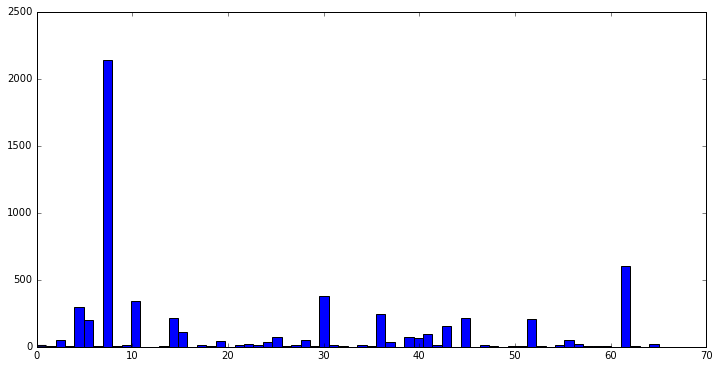

In [17]:
plt.figure(figsize=(12, 6))
h = plt.hist(y, bins=num_classes)

In [18]:
top_5_genres = list(enumerate(list(h[0])))
top_5_genres.sort(key = lambda s:s[1])
top_5_genres = map(lambda s: number_to_genre[s[0]], top_5_genres[-5:])
print top_5_genres

['dance', 'rap', 'electronics', 'rock', 'pop']


In [19]:
genre_to_number['pop']

7

# Nearest Neighbors genre classification

Let's try to solve similarity task by the nearest neighbour approach.

<img src="./img/nn.png" width="300">

Перемешаем датасет - используйте `np.random.permutation` и индексацию `a[np.random.permutation]`.

In [18]:
perm = np.random.permutation(len(y))
X, y = X[perm], y[perm]
Xreshape = X.reshape(X.shape[0], X.shape[1] * X.shape[2])

In [18]:
Xreshape = X.reshape(X.shape[0], X.shape[1] * X.shape[2])

In [19]:
Xreshape.shape

(12000, 55168)

In [20]:
from sklearn.preprocessing import scale
Xreshape = scale(Xreshape, copy=False)

Разобьем датасет на трейн и валидацию 80/20%.

In [24]:
train_numb = int(0.8 * X.shape[0])

X_train, X_valid = Xreshape[:train_numb], Xreshape[train_numb:]
y_train, y_valid = y[:train_numb], y[train_numb:]
print X_train.shape, X_valid.shape

(4800, 55168) (1200, 55168)


In [25]:
Xreshape.shape

(6000, 55168)

In [26]:
X_valid.shape

(1200, 55168)

Попробуем поклассифицировать жанры методом ближайших соседей.

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

def fit_and_classify(Classifier, **params):

    clf = Classifier(**params)
    clf = clf.fit(X_train, y_train)
    y_val_pred = clf.predict(X_valid)

    print accuracy_score(y_valid, y_val_pred), params

In [39]:
fit_and_classify(KNeighborsClassifier, n_jobs=-1, n_neighbors=3)

0.120833333333 {'n_neighbors': 3, 'n_jobs': -1}


In [40]:
fit_and_classify(KNeighborsClassifier, n_jobs=-1, n_neighbors=7)

0.138333333333 {'n_neighbors': 7, 'n_jobs': -1}


In [41]:
fit_and_classify(KNeighborsClassifier, n_jobs=-1, n_neighbors=9)

0.154166666667 {'n_neighbors': 9, 'n_jobs': -1}


In [42]:
fit_and_classify(KNeighborsClassifier, n_jobs=-1, n_neighbors=11)

0.155833333333 {'n_neighbors': 11, 'n_jobs': -1}


In [44]:
fit_and_classify(KNeighborsClassifier, n_jobs=-1, n_neighbors=15)

0.171666666667 {'n_neighbors': 13, 'n_jobs': -1}


In [45]:
fit_and_classify(KNeighborsClassifier, n_jobs=-1, n_neighbors=31)

0.220833333333 {'n_neighbors': 31, 'n_jobs': -1}


In [46]:
fit_and_classify(KNeighborsClassifier, n_jobs=-1, n_neighbors=51)

0.278333333333 {'n_neighbors': 51, 'n_jobs': -1}


In [47]:
fit_and_classify(KNeighborsClassifier, n_jobs=-1, n_neighbors=91)

0.334166666667 {'n_neighbors': 91, 'n_jobs': -1}


In [48]:
fit_and_classify(KNeighborsClassifier, n_jobs=3, n_neighbors=121)

0.350833333333 {'n_neighbors': 121, 'n_jobs': 3}


In [49]:
fit_and_classify(KNeighborsClassifier, n_jobs=3, n_neighbors=151)

0.368333333333 {'n_neighbors': 151, 'n_jobs': 3}


In [37]:
clf = KNeighborsClassifier(n_neighbors=221, n_jobs=-1)
clf.fit(Xreshape[:-2000], y[:-2000])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=221, p=2,
           weights='uniform')

In [38]:
predictions = clf.predict(Xreshape[-2000:])

In [39]:
import pandas as pd

solution = pd.DataFrame(columns=['Id','Category'])
solution.Category = [number_to_genre[s] for s in predictions]
solution.Id = 12000 + solution.index
solution.to_csv('solution_2.csv', index=False)

# Fully-Connected Neural Nets

Использовать нейросети - это хорошая идея, давайте начнем с полносвязных сетей.

In [1]:
import theano
import lasagne
import theano.tensor as T
from utils_music import train_net
import numpy as np
import os

Using gpu device 0: GeForce 840M (CNMeM is enabled with initial size: 85.0% of memory, cuDNN not available)


In [3]:
import numpy as np

BP = "./musicdata/"
X = np.load(os.path.join(BP, "spectrograms", "spectrograms1.pcl"))

In [4]:
X = np.concatenate([X, np.load(os.path.join(BP, "spectrograms", "spectrograms{}.pcl".format(2)))])
X.shape

(4000, 128, 431)

In [5]:
X = np.concatenate([X, np.load(os.path.join(BP, "spectrograms", "spectrograms{}.pcl".format(3)))])
X.shape

(6000, 128, 431)

In [6]:
X = np.concatenate([X, np.load(os.path.join(BP, "spectrograms", "spectrograms{}.pcl".format(4)))])
X.shape

(8000, 128, 431)

In [7]:
with open(os.path.join(BP, "train_genres.txt"), "rt") as f_in:
    train_genres = f_in.readlines()

train_genres = map(lambda s: s.strip(), train_genres)
genre_to_number = {genre : number for number, genre in enumerate(set(train_genres))}
number_to_genre = {number : genre for genre, number in genre_to_number.iteritems()}

num_classes = len(set(train_genres))

print num_classes
y = np.array(map(lambda s: genre_to_number[s], train_genres[:X.shape[0]]))

67


Перемешаем и разобьем датасет.

In [4]:
perm = np.random.permutation(len(y))
X, y = np.array(X)[perm].astype('float32'), np.array(y)[perm]

In [8]:
train_numb = int(0.8 * X.shape[0])
X_train, X_valid = X[:train_numb], X[train_numb:]
y_train, y_valid = y[:train_numb], y[train_numb:]

In [6]:
from lasagne.nonlinearities import softmax
from lasagne.updates import adam

In [7]:
input_X, target_y = T.tensor4("X", dtype='float32'), T.vector("y", dtype='int32')
nn = lasagne.layers.InputLayer(shape=(None, 1, X.shape[1], X.shape[2]), input_var=input_X) 
nn = lasagne.layers.DenseLayer(nn, num_units=100)
nn = lasagne.layers.DropoutLayer(nn)
nn = lasagne.layers.DenseLayer(nn, num_units=num_classes, nonlinearity=softmax)
y_predicted = lasagne.layers.get_output(nn)
all_weights = lasagne.layers.get_all_params(nn)
loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()
updates_sgd = adam(loss, all_weights, learning_rate=0.02) #???? ваш любимый оптимизатор

In [8]:
train_fun = theano.function([input_X, target_y], [loss, accuracy], allow_input_downcast=True, updates=updates_sgd)
test_fun  = theano.function([input_X, target_y], [loss, accuracy], allow_input_downcast=True)

In [9]:
%time conv_nn = train_net(nn, train_fun, test_fun, X_train, y_train, X_valid, y_valid, num_epochs=10, batch_size=50)

Epoch   1 of  10 train_loss = 1410.49 val_loss = 2.76 train_acc = 31.34 val_acc = 36.31
Epoch   2 of  10 train_loss = 2.72 val_loss = 2.63 train_acc = 34.88 val_acc = 36.31
Epoch   3 of  10 train_loss = 2.67 val_loss = 2.61 train_acc = 34.88 val_acc = 36.31
Epoch   4 of  10 train_loss = 2.66 val_loss = 2.61 train_acc = 34.88 val_acc = 36.31
Epoch   5 of  10 train_loss = 2.66 val_loss = 2.60 train_acc = 34.88 val_acc = 36.31
Epoch   6 of  10 train_loss = 2.66 val_loss = 2.60 train_acc = 34.88 val_acc = 36.31
Epoch   7 of  10 train_loss = 2.66 val_loss = 2.60 train_acc = 34.88 val_acc = 36.31
Epoch   8 of  10 train_loss = 2.66 val_loss = 2.60 train_acc = 34.88 val_acc = 36.31
Epoch   9 of  10 train_loss = 2.66 val_loss = 2.60 train_acc = 34.88 val_acc = 36.31
Epoch  10 of  10 train_loss = 2.66 val_loss = 2.61 train_acc = 34.88 val_acc = 36.31
CPU times: user 42.5 s, sys: 8.15 s, total: 50.7 s
Wall time: 51.2 s


# Convolution Neural Nets

Да, вероятно, полносвязные сети не зажгли и kNN не обогнали. Давайте попробуем сверточные, хороший вариант делать одномерные свертки (сразу по всем частотам). Хотя двумерные тоже могут работать. 

Архитектуру можно подсмотреть [тут](http://benanne.github.io/2014/08/05/spotify-cnns.html).

In [1]:
import theano
import lasagne
import theano.tensor as T
from utils_music import train_net
import numpy as np
import os
import matplotlib.pyplot as plt
import theano
import lasagne
import theano.tensor as T
from utils_music import train_net
from sklearn.preprocessing import scale
from lasagne.nonlinearities import softmax, sigmoid, rectify

%pylab inline

Using gpu device 0: GeForce 840M (CNMeM is enabled with initial size: 85.0% of memory, cuDNN not available)


Populating the interactive namespace from numpy and matplotlib


In [ ]:
import numpy as np

BP = "./musicdata/"
X = np.load(os.path.join(BP, "spectrograms", "spectrograms1.pcl"))

In [ ]:
X = np.concatenate([X, np.load(os.path.join(BP, "spectrograms", "spectrograms{}.pcl".format(2)))])
X.shape

In [ ]:
X = np.concatenate([X, np.load(os.path.join(BP, "spectrograms", "spectrograms{}.pcl".format(3)))])
X.shape

In [ ]:
X = np.concatenate([X, np.load(os.path.join(BP, "spectrograms", "spectrograms{}.pcl".format(4)))])
X.shape

In [95]:
some_pop_indecies = filter(lambda i: y[i] == genre_to_number['pop'] , range(len(y)))[:-700]
some_rock_indecies = filter(lambda i: y[i] == genre_to_number['rock'] , range(len(y)))[:-700]
not_in_ind_lists = np.array(filter(lambda x: x not in some_pop_indecies and\
                                      x not in some_rock_indecies, range(len(y))))
# print len(pop_indecies)

X, y = X[not_in_ind_lists], y[not_in_ind_lists]

In [ ]:
perm = np.random.permutation(len(y))
X, y = np.array(X)[perm].astype('float32'), np.array(y)[perm]

train_numb = int(0.8 * X.shape[0])
X_train, X_valid = X[:train_numb], X[train_numb:]
y_train, y_valid = y[:train_numb], y[train_numb:]

In [15]:
print len(X_train), len(y_train), len(X_valid), len(y_valid)

6400 6400 1600 1600


In [21]:
input_X, target_y = T.tensor3("X", dtype='float32'), T.vector("y", dtype='int32')

nn = lasagne.layers.InputLayer(shape=(None, X.shape[1], X.shape[2]), input_var=input_X)

nn = lasagne.layers.Conv1DLayer(nn, num_filters=64, filter_size=4, flip_filters=False)
nn = lasagne.layers.MaxPool1DLayer(nn, 4)

nn = lasagne.layers.Conv1DLayer(nn, num_filters=64, filter_size=4, flip_filters=False)
nn = lasagne.layers.MaxPool1DLayer(nn, pool_size=2)

nn = lasagne.layers.Conv1DLayer(nn, num_filters=32, filter_size=4, flip_filters=False)
nn_max = lasagne.layers.Pool1DLayer(nn, pool_size=4, mode='max')
nn_mean = lasagne.layers.Pool1DLayer(nn, pool_size=4, mode='average_exc_pad')
nn = lasagne.layers.ConcatLayer([nn_max, nn_mean])

# nn['conv4'] = lasagne.layers.Conv1DLayer(nn['maxpool3'], num_filters=128, filter_size=4, flip_filters=False)
# nn['maxpool4'] = lasagne.layers.MaxPool1DLayer(nn['conv4'], pool_size=2)

#nn = lasagne.layers.DenseLayer(nn, num_units=512)
#nn = lasagne.layers.DropoutLayer(nn, p=0.25)

nn = lasagne.layers.DenseLayer(nn, num_units=512)
#nn = lasagne.layers.DropoutLayer(nn, p=0.25)

nn = lasagne.layers.DenseLayer(nn, num_classes, nonlinearity=None)
nn = lasagne.layers.DropoutLayer(nn, p=0.25)

nn = lasagne.layers.NonlinearityLayer(nn, nonlinearity=softmax)

y_predicted = lasagne.layers.get_output(nn)
y_predicted_det = lasagne.layers.get_output(nn, deterministic=True)
all_weights = lasagne.layers.get_all_params(nn)

In [22]:
loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()

loss_test = lasagne.objectives.categorical_crossentropy(y_predicted_det, target_y).mean()
accuracy_test = lasagne.objectives.categorical_accuracy(y_predicted_det, target_y).mean()

updates_sgd = lasagne.updates.adam(loss, all_weights)

In [ ]:
train_fun = theano.function([input_X, target_y], [loss, accuracy],
                            allow_input_downcast=True, updates=updates_sgd)
test_fun  = theano.function([input_X, target_y], [loss, accuracy],
                            allow_input_downcast=True)

In [ ]:
%time nn = train_net(nn, train_fun, test_fun, X_train.astype('float32'), y_train,\
                     X_valid.astype('float32'), y_valid, num_epochs=30, batch_size=100)

Epoch   1 of  30 train_loss = 6.555 val_loss = 3.143 train_acc = 24.828 val_acc = 26.375


In [17]:
y_predicted_conv = lasagne.layers.get_output(nn, deterministic=True)
y_classes = y_predicted_conv.argmax(axis=1)
get_output = theano.function([input_X], y_classes)

In [19]:
predictions = get_output(X_valid.astype('float32'))

In [20]:
set(predictions)

{2, 4, 7, 10, 14, 30, 31, 40, 43, 45, 57, 62}

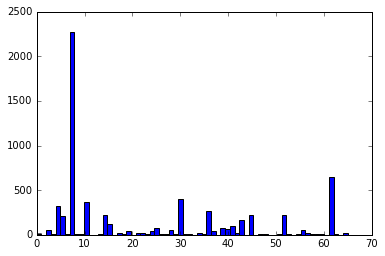

In [11]:
import matplotlib.pyplot as plt
h = plt.hist(y_train, bins=num_classes)
plt.show()

Валидационная точность должна быть около 0.6 или лучше. 

Давайте нарисуем каждый второй фильтр - можете ли вы проинтерпретировать эти фильтры?

In [ ]:
plt.figure(figsize=(5, 5), dpi=500)
W = lasagne.layers.get_all_params(nn)[0].get_value()
W[::2, :, :] = 0.2
W = np.hstack(W)
pylab.imshow(W, cmap='hot', interpolation="nearest")
pylab.axis('off')
pylab.show()

# Maps of tracks by SVD and tSNE

Хорошая идея посмотреть, как полученое представление отображается с сохранением относительных расстояний на плоскость. Используйте tSNE или PCA.

Help: https://lts2.epfl.ch/blog/perekres/category/visualizing-hidden-structures-in-datasets-using-deep-learning/

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
represent = lasagne.layers.get_output(nn.input_layer)
represent_fun = theano.function([input_X], [represent], allow_input_downcast=True)

In [ ]:
f = lambda x: np.array(represent_fun([x])[0])
track_vectors = map(f, X_train) + map(f, X_valid)
track_vectors = np.concatenate(track_vectors, axis=0)

track_labels = np.array(list(y_train) + list(y_valid))

получите 2d вектора

In [ ]:
X_tsne = ????

нарисуйте получившиеся точки

In [ ]:
plt.figure(figsize=(10,10), dpi=500)
colors = cm.hot(np.linspace(0, 1, len(id2gener)))

for idx, gener in id2gener.items():
    idx_ = np.where(track_labels == idx)
    pylab.scatter(????, ????, c=colors[idx], cmap=cm.hot, label=gener,s=50)

pylab.legend(loc=0, ncol=5)